In [1]:
from __future__ import print_function
import numpy as np
import os
import sys
import time
import pickle
import tensorflow as tf

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Configuration for TF Session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

## Guided ReLU for guided backpropogation

Source: https://github.com/adityac94/Grad_CAM_plus_plus/blob/master/misc/GuideReLU.py

In [4]:
# Replace vanila relu to guided relu to get guided backpropagation.
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops
import tensorflow as tf

@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops.relu_grad(grad, op.outputs[0]), tf.zeros_like(grad))

## Retrieve the dataset generator

In [5]:
index = os.path.abspath('/home/mayankm/my_projects/data/kitti/KITTI_index.csv')
test_selector = '2011_09_30'
n_test_samples = 5
batch_size = 1
buffer_size = 32
model_path = os.path.abspath('models/miscalib-model-cam03/')
model_name = 'model-22-46483'
verbosity = 1
njobs = 9

print('KITTI Index File: ' + index)
print('Model Path: ' + model_path)

KITTI Index File: /home/mayankm/my_projects/data/kitti/KITTI_index.csv
Model Path: /media/storage/my_projects/semantics_miscalib_PLR/plr_miscalib_detection/models/miscalib-model-cam03


In [6]:
# Load the dataset.
from dataset import Dataset

dataset_test = Dataset(index, selector=test_selector, internal_shuffle=True,
                       num_of_samples=n_test_samples, n_jobs=njobs, verbose=verbosity)

1230 images found in 2 folders grouped in 2 groups from index file /home/mayankm/my_projects/data/kitti/KITTI_index.csv, when applying selector '2011_09_30'.
The samplers were initialized in 32.86 sec.


In [7]:
from __future__ import unicode_literals
# Load previous scaler
scaler_path = os.path.join(model_path, 'scaler.p')
scaler = pickle.load(open(scaler_path, 'rb'), encoding='latin1')
dataset_test.set_scaler(scaler)

print('Test with %d images' % (dataset_test.n_samples))

ids_test = np.arange(dataset_test.n_samples)

Test with 5 images


In [8]:
# Create batch generators for the test sets.
from generator import Generator

gen_test = Generator(dataset_test, ids_test, batch_size=batch_size, shuffle=True,
                     buffer_size=buffer_size, verbose=verbosity)

# Define tf model.
import tensorflow as tf
tf.reset_default_graph()

# Set tensorflow to only log errors
if verbosity == 0:
    tf.logging.set_verbosity(tf.logging.ERROR)

Filling generator buffer. Done


## Implementation of GradCAM++

In [9]:
from skimage.transform import resize
from scipy.ndimage.interpolation import zoom

In [10]:
def compute_gradcam_plusplus(conv_output, conv_first_grad, conv_second_grad, conv_third_grad, shape=(512, 1392)):
    """ Computes the GradCAM++
    """
    print("\nShape of Conv Layer: ", conv_output.shape)
    
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)
    
    #normalizing the alphas
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)

    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))
    
    """
    alphas_thresholding = np.where(weights, alphas, 0.0)

    alpha_normalization_constant = np.sum(np.sum(alphas_thresholding, axis=0),axis=0)
    alpha_normalization_constant_processed = np.where(alpha_normalization_constant != 0.0, alpha_normalization_constant, np.ones(alpha_normalization_constant.shape))


    alphas /= alpha_normalization_constant_processed.reshape((1,1,conv_first_grad[0].shape[2]))
    """
    
    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)
    
    # print deep_linearization_weights
    grad_CAM_map = np.sum(deep_linearization_weights * conv_output[0], axis=2)

    # Passing through ReLU
    cam = np.maximum(grad_CAM_map, 0)
    cam = zoom(cam, shape[0] / cam.shape[0])
    cam = cam / np.max(cam) # scale 0 to 1.0    
    
    # return the cam array
    return cam

In [11]:
def compute_gradcam(conv_output, conv_first_grad, shape=(512, 1392)):
    """ Computes the GradCAM
    """    
    output, grads_val = conv_output[0], conv_first_grad[0]
    
    weights = np.mean(grads_val, axis=(0, 1))
    grad_CAM_map = np.dot(output, weights)
    
    # Passing through ReLU
    cam = np.maximum(grad_CAM_map, 0)
    cam = zoom(cam, shape[0] / cam.shape[0])
    cam = cam / np.max(cam) # scale 0 to 1.0    
    
    # return the cam array
    return cam

In [12]:
import cv2

def visualize_cam(img, cam, gb_viz=None, shape=(512, 1392)):
  
    fig, _ = plt.subplots(nrows=2,ncols=1)
    
    cam = (cam*-1.0) + 1.0
    cam_heatmap = np.array(cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET))
    
    ax = plt.subplot(211)
    plt.axis("off")
    plt.imshow(img, aspect='auto')
    ax.set_title('Image')
    
    ax = plt.subplot(212)
    plt.axis("off")
    plt.imshow(img)
    plt.imshow(cam_heatmap, alpha=0.5, aspect='auto')
    ax.set_title('Heatmap')
    
#     gb_viz = np.dstack((
#             gb_viz[:, :, 0],
#             gb_viz[:, :, 1],
#             gb_viz[:, :, 2],
#         ))       
#     gb_viz -= np.min(gb_viz)
#     gb_viz /= gb_viz.max()

#     ax = plt.subplot(313)
#     plt.axis("off")
#     imgplot = plt.imshow(gb_viz, aspect='auto')
#     ax.set_title('guided backpropagation')

In [13]:
# Load previous metegraph
from model import test_model

# Get default TF graph
graph = tf.get_default_graph()

with graph.as_default():
    with graph.gradient_override_map({'Relu': 'GuidedRelu'}):

        print("Input shape: ", dataset_test.shape)
        test_model(dataset_test.shape)

Input shape:  (512, 1392, 3)


In [14]:
#  get the names of all the tensors in the graph
for n in graph.as_graph_def().node:
    print(n.name)        

input_image
y_true
Const
training
conv_block_1/conv1/kernel/Initializer/random_uniform/shape
conv_block_1/conv1/kernel/Initializer/random_uniform/min
conv_block_1/conv1/kernel/Initializer/random_uniform/max
conv_block_1/conv1/kernel/Initializer/random_uniform/RandomUniform
conv_block_1/conv1/kernel/Initializer/random_uniform/sub
conv_block_1/conv1/kernel/Initializer/random_uniform/mul
conv_block_1/conv1/kernel/Initializer/random_uniform
conv_block_1/conv1/kernel
conv_block_1/conv1/kernel/IsInitialized/VarIsInitializedOp
conv_block_1/conv1/kernel/Assign
conv_block_1/conv1/kernel/Read/ReadVariableOp
conv_block_1/conv1/bias/Initializer/zeros
conv_block_1/conv1/bias
conv_block_1/conv1/bias/IsInitialized/VarIsInitializedOp
conv_block_1/conv1/bias/Assign
conv_block_1/conv1/bias/Read/ReadVariableOp
conv_block_1/conv1/dilation_rate
conv_block_1/conv1/Conv2D/ReadVariableOp
conv_block_1/conv1/Conv2D
conv_block_1/conv1/BiasAdd/ReadVariableOp
conv_block_1/conv1/BiasAdd
conv_block_1/conv1/Relu
conv

In [15]:
# Inputs.
input_image_tf = graph.get_tensor_by_name('input_image:0')
y_true_tf = graph.get_tensor_by_name('y_true:0')

training_tf = graph.get_tensor_by_name('training:0')

loss_tf = graph.get_tensor_by_name('loss_mse:0')
error_tf = graph.get_tensor_by_name('error_mae:0')

# Global step for logging.
global_step = 0

# Conv layer state for GradCAM
target_conv_layer_tf = graph.get_tensor_by_name('conv_block_7/conv2/Relu:0')
output_neuron_tf = graph.get_tensor_by_name('Squeeze:0')

In [16]:
with graph.as_default():
    with graph.gradient_override_map({'Relu': 'GuidedRelu'}):
        with tf.name_scope('gradcam'):
            # get the output neuron corresponding to the class of interest (label_id)
            cost_tf = loss_tf

            # get last convolutional layer gradients for generating gradCAM++ visualization
            target_conv_layer_grad_tf = tf.gradients(cost_tf, target_conv_layer_tf)[0]

            # first_derivative
            first_derivative_tf = tf.exp(cost_tf) * target_conv_layer_grad_tf
            # second_derivative
            second_derivative_tf = tf.exp(cost_tf) * target_conv_layer_grad_tf * target_conv_layer_grad_tf 
            # triple_derivative
            triple_derivative_tf = tf.exp(cost_tf) * target_conv_layer_grad_tf * target_conv_layer_grad_tf * target_conv_layer_grad_tf
            # get gradients with respect to input for guided backprop
            gb_grad_tf = tf.gradients(cost_tf, input_image_tf)

INFO:tensorflow:Restoring parameters from /media/storage/my_projects/semantics_miscalib_PLR/plr_miscalib_detection/models/miscalib-model-cam03/model-22-46483
Groundtruth:  [1.23528911]  Prediction:  1.0701312

Shape of Conv Layer:  (1, 8, 21, 128)
Groundtruth:  [0.77957632]  Prediction:  1.1262759

Shape of Conv Layer:  (1, 8, 21, 128)
Groundtruth:  [0.50054263]  Prediction:  0.8111073

Shape of Conv Layer:  (1, 8, 21, 128)
Groundtruth:  [0.51601586]  Prediction:  0.7487351

Shape of Conv Layer:  (1, 8, 21, 128)
Groundtruth:  [1.19377515]  Prediction:  0.83318543

Shape of Conv Layer:  (1, 8, 21, 128)


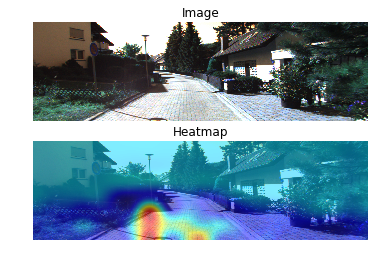

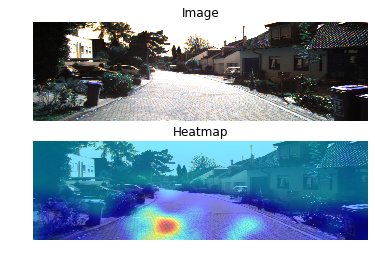

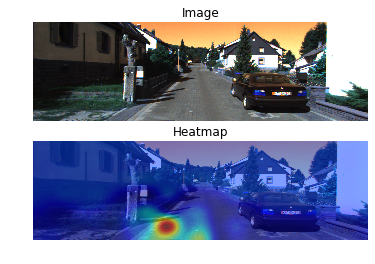

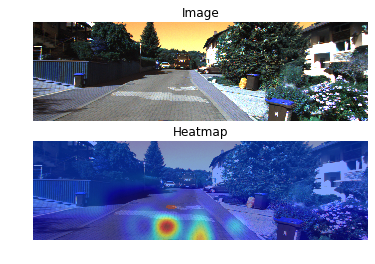

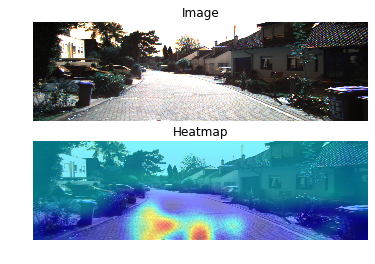

In [19]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

with tf.Session(config=config) as sess:
    # Initialize tf variables.
    tf.global_variables_initializer().run()

    # load the model
    model_file = os.path.join(model_path, model_name)
    saver.restore(sess, model_file)

    # Sequence of train and validation batches.
    test_step = 0
    console_output_size = 0

    for b in range(gen_test.n_batches):
        images_batch, labels_batch = gen_test.next()

        # Calculate validation loss.
        batch_loss, batch_error, y_pred = sess.run(
            [loss_tf, error_tf, output_neuron_tf],
            feed_dict={input_image_tf: images_batch,
                       y_true_tf: labels_batch})

        # Print results.
        print('Groundtruth: ', labels_batch, ' Prediction: ', y_pred)
        
        # Compute the GradCAM gradients
        conv_output, conv_first_grad, conv_second_grad, conv_third_grad = sess.run(
            [target_conv_layer_tf, first_derivative_tf, second_derivative_tf, triple_derivative_tf], 
            feed_dict={input_image_tf: images_batch,
                       y_true_tf: labels_batch})

        # Compute the guided backprop 
        gb_grad_value = sess.run(
            gb_grad_tf, 
            feed_dict={input_image_tf: images_batch,
                       y_true_tf: labels_batch})
        
        # Unnormalize the image
        scaler = dataset_test.get_scaler()
        images_batch_un = np.reshape(images_batch, (images_batch.shape[0], -1))
        images_batch_un = scaler.inverse_transform(images_batch_un)
        images_batch_un = np.reshape(images_batch_un, images_batch.shape)
        images_batch_un = images_batch_un.astype(dtype='int')
        
        # Visualize the result of GradCAM++
        cam = compute_gradcam_plusplus(conv_output, conv_first_grad, conv_second_grad, conv_third_grad)
        visualize_cam(images_batch_un[0], cam)
        
        # Visualize the result of GradCAM
#         cam = compute_gradcam(conv_output, conv_first_grad)
#         visualize_cam(images_batch_un[0], cam)
        

## Model Evalutation

In [28]:
with tf.Session(config=config) as sess:
    # Initialize tf variables.
    tf.global_variables_initializer().run()

    model_file = os.path.join(model_path, model_name)
    saver.restore(sess, model_file)
    
    # Sequence of train and validation batches.
    test_loss = 0
    test_error = 0
    test_step = 0

    console_output_size = 0
    for b in range(gen_test.n_batches):
        images_batch, labels_batch = gen_test.next()

        # Calculate validation loss.
        batch_loss, batch_error = sess.run(
            [loss_tf, error_tf],
            feed_dict={input_image_tf: images_batch,
                       y_true_tf: labels_batch})
        test_loss += batch_loss
        test_error += batch_error
        test_step += 1

        # Print results.
        sys.stdout.write('\b' * console_output_size)

        console_output = 'step %5d ' % test_step
        console_output += 'Test: loss_mse: %.4f err_mae %.4f' % (
            test_loss / test_step, test_error / test_step)

        console_output_size = len(console_output)

        sys.stdout.write(console_output)
        sys.stdout.flush()

    print()

INFO:tensorflow:Restoring parameters from /media/storage/my_projects/semantics_miscalib_PLR/plr_miscalib_detection/models/miscalib-model-cam03/model-22-46483


NotFoundError: Key beta1_power_1 not found in checkpoint
	 [[Node: save_8/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_8/Const_0_0, save_8/RestoreV2/tensor_names, save_8/RestoreV2/shape_and_slices)]]
	 [[Node: save_8/RestoreV2/_147 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_220_save_8/RestoreV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'save_8/RestoreV2', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tornado/gen.py", line 708, in __init__
    self.run()
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3209, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-d9779e266f40>", line 2, in <module>
    saver = tf.train.Saver()
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1284, in __init__
    self.build()
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1296, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1333, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 781, in _build_internal
    restore_sequentially, reshape)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 400, in _AddRestoreOps
    restore_sequentially)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 832, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1463, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/home/mayankm/.virtualenvs/plr_pytorch/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key beta1_power_1 not found in checkpoint
	 [[Node: save_8/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_8/Const_0_0, save_8/RestoreV2/tensor_names, save_8/RestoreV2/shape_and_slices)]]
	 [[Node: save_8/RestoreV2/_147 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_220_save_8/RestoreV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [45]:
dataset_test.stop()